In [1]:
import statistics
from typing import List

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.stats import pearsonr

import afnidespike

In [60]:
plt.rcParams["figure.dpi"] = 150
plt.style.use("seaborn-whitegrid")

/tmp/ipykernel_65648/1841111261.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
def sample_timeseries(num_samples: int, num_spikes: int, seed: int = 42):
    rng = np.random.default_rng(seed)
    data = np.sin(np.linspace(0, 16 * np.pi, num_samples))
    data += rng.normal(0, 0.1, size=num_samples)
    spike_indices = rng.choice(num_samples, num_spikes)
    data[spike_indices] += rng.uniform(10, 100, size=num_spikes)
    data = data.astype("float32")
    return data

In [4]:
def despike_afni(timeseries: np.ndarray, window: int = 25, inplace: bool = False):
    if window not in {9, 25}:
        raise ValueError(f"Invalid window {window}; only 25 or 9 supported")
    
    cleaned = timeseries.astype("float32")
    if not inplace:
        cleaned = cleaned.copy()
    afnidespike.despike(cleaned, int(window == 25))
    return cleaned

In [5]:
def despike_scipy(timeseries: np.ndarray, window: int = 25):
    rolling_med = ndimage.median_filter(timeseries, size=window)
    abs_dev = np.abs(timeseries - rolling_med)
    rolling_mad = ndimage.median_filter(abs_dev, size=window)
    spike_mask = (abs_dev / rolling_mad) > 6.789
    cleaned = np.where(spike_mask, rolling_med, timeseries)
    return cleaned

In [6]:
def despike_py(timeseries: List[float], window: int = 25):
    rolling_med = median_filter(timeseries, window=window)
    abs_dev = [abs(v - med) for v, med in zip(timeseries, rolling_med)]
    rolling_mad = median_filter(abs_dev, window=window)
    cleaned = []
    for ii, v in enumerate(timeseries):
        if abs_dev[ii] / rolling_mad[ii] > 6.789:
            cleaned.append(rolling_med[ii])
        else:
            cleaned.append(v)
    return cleaned


def median_filter(data: List[float], window: int = 25):
    half_window = window // 2
    
    filtered = []
    for ii in range(len(data)):
        start = max(ii - half_window, 0)
        stop = min(ii + half_window, len(data))
        filtered.append(statistics.median(data[start: stop]))
    return filtered

In [7]:
data = sample_timeseries(10_000, 10)

In [8]:
cleaned_afni = despike_afni(data)
cleaned_scipy = despike_scipy(data)
cleaned_py = despike_py(data.tolist())

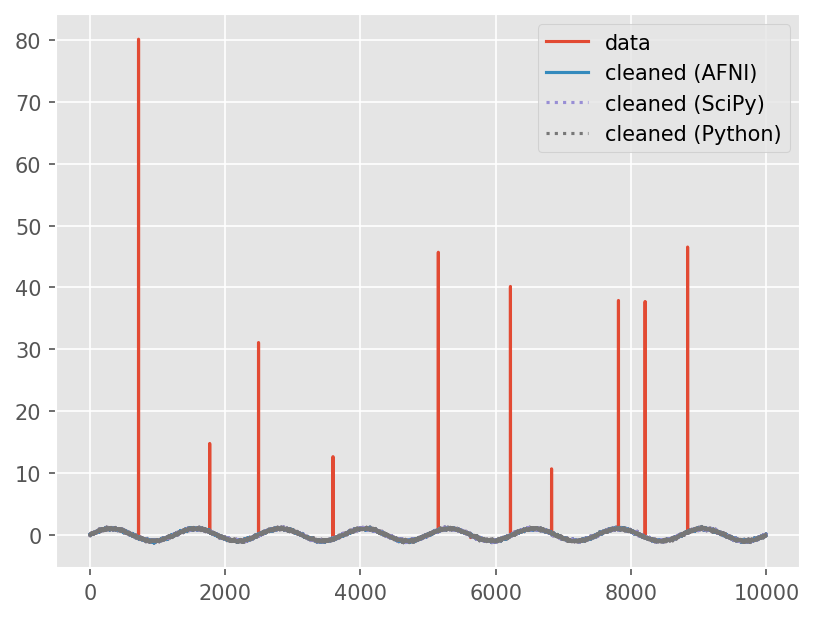

In [9]:
plt.plot(data, label="data")
plt.plot(cleaned_afni, label="cleaned (AFNI)")
plt.plot(cleaned_scipy, ":", label="cleaned (SciPy)")
plt.plot(cleaned_py, ":", label="cleaned (Python)")
plt.legend()

plt.show();

In [10]:
print(pearsonr(cleaned_afni, cleaned_scipy)[0])
print(pearsonr(cleaned_afni, cleaned_py)[0])

0.9999067612044648
0.9998955263415674


In [11]:
%timeit -n 100 despike_afni(data)

5 ms ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit -n 100 despike_scipy(data)

9.19 ms ± 86.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit -n 100 despike_py(data)

122 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
import timeit

def time_fun(fun, reps, *args, **kwargs):
    start_time = timeit.default_timer()
    for _ in range(reps):
        fun(*args, **kwargs)
    return timeit.default_timer() - start_time


data = sample_timeseries(10_000, 10)

d = {'method': [], 'num_points': [], 'time': []}

for method in [despike_py, despike_scipy, despike_afni]:
    for num_points in [25, 50, 100, 500, 1000, 5000, 10000]:
        print(f'Running {method.__name__} n={num_points}')

        d['method'].append(method.__name__)
        d['num_points'].append(num_points)
        d['time'].append(time_fun(method, 100, data[:num_points]))




Running despike_py n=25
Running despike_py n=50
Running despike_py n=100
Running despike_py n=500
Running despike_py n=1000
Running despike_py n=5000
Running despike_py n=10000
Running despike_scipy n=25
Running despike_scipy n=50
Running despike_scipy n=100
Running despike_scipy n=500
Running despike_scipy n=1000
Running despike_scipy n=5000
Running despike_scipy n=10000
Running despike_afni n=25
Running despike_afni n=50
Running despike_afni n=100
Running despike_afni n=500
Running despike_afni n=1000
Running despike_afni n=5000
Running despike_afni n=10000


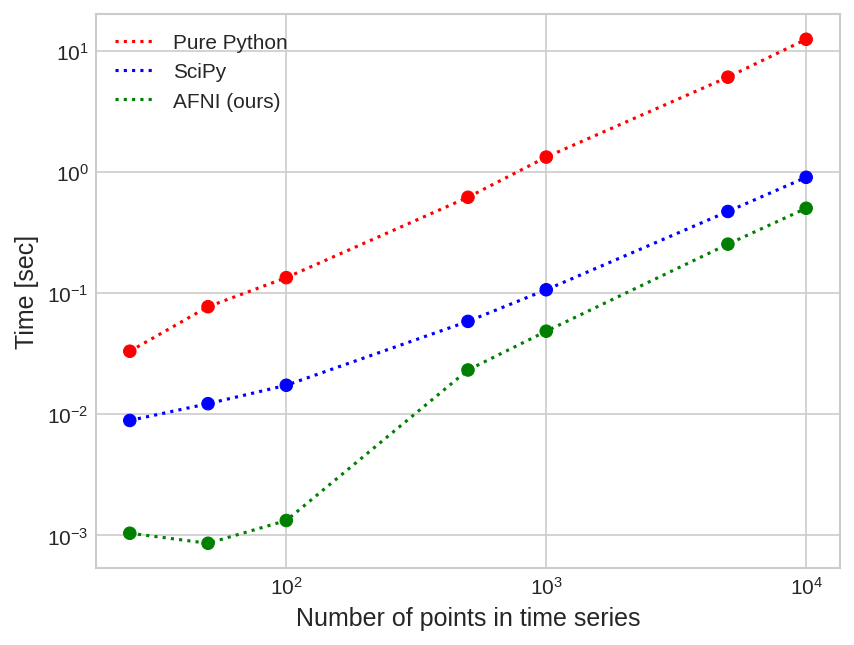

In [64]:
import pandas as pd


df = pd.DataFrame(d)

colors = { 'despike_py': 'red', 'despike_scipy': 'blue', 'despike_afni': 'green' }

#df.plot.scatter(x = 'num_points', y = 'time', c = df['method'].apply(colors.__getitem__), logx=True, logy=True)

plt.xscale('log')
plt.yscale('log')
plt.plot(df[df['method'] == 'despike_py']['num_points'].values, df[df['method'] == 'despike_py']['time'].values, linestyle = 'dotted', color='red', label='Pure Python')
plt.plot(df[df['method'] == 'despike_scipy']['num_points'].values, df[df['method'] == 'despike_scipy']['time'].values, linestyle = 'dotted', color='blue', label='SciPy')
plt.plot(df[df['method'] == 'despike_afni']['num_points'].values, df[df['method'] == 'despike_afni']['time'].values, linestyle = 'dotted', color='green', label='AFNI (ours)')

plt.xlabel("Number of points in time series")
plt.ylabel("Time [sec]")

plt.scatter(df['num_points'].values, df['time'].values, color=df['method'].apply(colors.__getitem__).values)
plt.legend()

In [65]:
df

,method,num_points,time
0,despike_py,25,0.033179
1,despike_py,50,0.077321
2,despike_py,100,0.134375
3,despike_py,500,0.619025
4,despike_py,1000,1.329110
5,despike_py,5000,6.070416
6,despike_py,10000,12.472368
7,despike_scipy,25,0.008903
8,despike_scipy,50,0.012243
9,despike_scipy,100,0.017380
